In [205]:
'''
Multiplexed Convolutional Neural Network Implementation on MNIST
Vin Ay

Input  : [Image, Control Signal] -> Image = B/W or W/B Digits, Control Signal = 0 (for B/W), 1 (for W/B)
Output : [Digit Index]
'''

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Softmax
from keras.layers import Conv2D, MaxPooling2D, Input
from keras import backend as K
from keras.models import Model
from multiplexer import Multiplexer

import numpy as np
import random


batch_size = 128
num_classes = 10
epochs = 10

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28,1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Create Invert Color dataset for other branch of the network
x_train_inv = 1 - x_train
x_test_inv = 1 - x_test


print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)



x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [206]:
# Build data batch generator for Training and Testing

def getTrainBatch(batch_size):
    while True:
        batch_x = []
        batch_c = []
        batch_y = []
        for i in range(batch_size):
            ch = random.randint(0,1)
            ch2 = random.randint(0, 60000-1)
            if ch == 0:
                batch_x.append(x_train[ch2])
                batch_c.append(ch)
                batch_y.append(y_train[ch2])

            else:
                batch_x.append(x_train_inv[ch2])
                batch_c.append(ch)
                batch_y.append(y_train[ch2])

        yield([np.array(batch_x), np.array(batch_c)], np.array(batch_y))
    
def getTestBatch(batch_size):
    while True:
        batch_x = []
        batch_c = []
        batch_y = []
        for i in range(batch_size):
            ch = random.randint(0,1)
            ch2 = random.randint(0, 10000-1)
            if ch == 0:
                batch_x.append(x_test[ch2])
                batch_c.append(ch)
                batch_y.append(y_test[ch2])

            else:
                batch_x.append(x_test_inv[ch2])
                batch_c.append(ch)
                batch_y.append(y_test[ch2])

        yield([np.array(batch_x), np.array(batch_c)], np.array(batch_y))
    

In [208]:
# Build Multiplexed Model for training both types of data separately 

input_shape = (28, 28,1)
input_im = Input(shape = input_shape)
control = Input(shape = (1,), dtype = 'int32')

x = Conv2D(32, (3,3), activation = 'relu')(input_im)
x = MaxPooling2D(pool_size = (2,2))(x)
x = Conv2D(64, (3,3), activation = 'relu')(x)
x = MaxPooling2D(pool_size = (2,2))(x)
x = Dropout(0.25)(x)
x = Flatten()(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.5)(x)
x = Dense(2*num_classes)(x)

output = Multiplexer(num_classes, 2)([x, control])
output = Softmax()(output)

model = Model([input_im, control], output)

# Save model image on disk
from keras.utils import plot_model
plot_model(model, to_file='model.png')

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

# Start training the model
model.fit_generator(getTrainBatch(batch_size),
                    epochs=epochs,
                    verbose=1,
                    steps_per_epoch=len(x_train)/batch_size,
                    validation_data=getTestBatch(batch_size),
                    validation_steps = len(x_test)/batch_size                   
                   )


Epoch 1/10
469/468 [==============================] - 40s 84ms/step - loss: 0.4353 - accuracy: 0.8620 - val_loss: 0.1087 - val_accuracy: 0.9701
Epoch 2/10
469/468 [==============================] - 38s 81ms/step - loss: 0.1441 - accuracy: 0.9564 - val_loss: 0.0356 - val_accuracy: 0.9808
Epoch 3/10
469/468 [==============================] - 38s 82ms/step - loss: 0.1107 - accuracy: 0.9665 - val_loss: 0.0769 - val_accuracy: 0.9849
Epoch 4/10
469/468 [==============================] - 38s 82ms/step - loss: 0.0951 - accuracy: 0.9706 - val_loss: 0.0551 - val_accuracy: 0.9845
Epoch 5/10
469/468 [==============================] - 38s 82ms/step - loss: 0.0827 - accuracy: 0.9750 - val_loss: 0.0347 - val_accuracy: 0.9871
Epoch 6/10
469/468 [==============================] - 39s 82ms/step - loss: 0.0768 - accuracy: 0.9773 - val_loss: 0.0840 - val_accuracy: 0.9861
Epoch 7/10
469/468 [==============================] - 39s 83ms/step - loss: 0.0655 - accuracy: 0.9803 - val_loss: 0.0361 - val_accuracy:

In [209]:
# Save model on disk
model.save("mnist_10ep.h5")

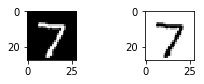

7 : 0.99999785   7 : 1.0


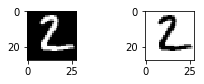

2 : 0.99999   2 : 0.9999033


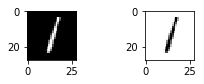

1 : 0.99999535   1 : 0.99999106


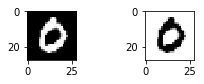

0 : 0.99998546   0 : 0.9999186


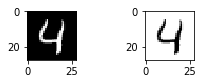

4 : 0.99995923   4 : 0.99995947


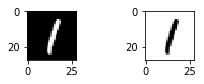

1 : 0.9999976   1 : 0.99999464


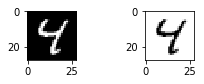

4 : 0.99528956   4 : 0.96976286


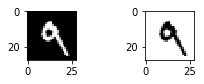

9 : 0.99952793   9 : 0.9982969


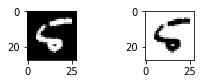

5 : 0.9998573   5 : 0.9992526


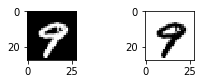

9 : 0.9999075   9 : 0.99977165


In [212]:
'''
Plotting images to visualize output of the network
'''

import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import time

for i in range(10):
    plt.figure(figsize=(3, 3))
    plt.subplot(1, 3, 1)
    im = tf.keras.preprocessing.image.array_to_img( x_test[i], data_format=None, scale=True,dtype=None)
    plt.imshow(im, cmap="gray")
    plt.subplot(1, 3, 3)
    im2 = tf.keras.preprocessing.image.array_to_img( x_test_inv[i], data_format=None, scale=True,dtype=None)
    plt.imshow(im2, cmap="gray")
    plt.show()
    
    black_res = model.predict([x_test[i].reshape(1,28,28,1),np.array([0])])
    white_res = model.predict([x_test_inv[i].reshape(1,28,28,1),np.array([1])])
    
    b_ind = np.argmax(black_res)
    w_ind = np.argmax(white_res)
    
    print(b_ind,":",black_res[0][b_ind]," ", w_ind,":",white_res[0][w_ind])
    
